# Excercise NN/02 - Neural Networks

Contact: Dr. David C. Schedl <br/>
E-Mail: david.schedl@fh-hagenberg.at <br/>
Note: this tutorial is geared towards students **experienced in programming** and aims to introduce you to **Backpropagation and NNs**.

*Acknowledgements:*
This notebook is strongly inspired by the NN-zero-to-here lecture series by Andrej Karpathy, available [here](https://github.com/karpathy/nn-zero-to-hero).


## Setup
As first step, we need to import the necessary libraries. 

In [ ]:
# Setup and import of libraries
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs, make_circles


# Let's set the random seed to make this reproducible (the same for everybody).
np.random.seed(1337)
random.seed(1337)

### Visualization Helpers

The following functions will help us to visualize the compute graph.

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%sdata %.4f | grad %.4f}" % (f"{n.label} |" if n.label else '', n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

# Backpropagation
This is where the magic happens ... ✨ <br>

Let's finish backpropagation by implementing the chain rule in our `Value` class. <br>

In [ ]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None # This is new!
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    # TODO: implement the backward pass for addition
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    # TODO: implement the backward pass for multiplication
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    # TODO: implement the backward pass for **

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):

    out = Value( math.tanh(self.data), (self,), 'tanh')

    # TODO: implement the backward pass for tanh
    
    return out  

  def relu(self):
    out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

    # TODO: implement the backward pass for ReLU

    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    # TODO: implement the backward pass for exp
    
    return out
  
  
  def backward(self):
    
    # get a topographic sort of the graph for backprop
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    # set the gradient of all nodes to 0
    for n in topo:
      n.grad = 0.0
    
    self.grad = 1.0 # set the gradient of the last node to 1

    # TODO: finish the backward pass!

# We want to compute the gradients by calling backward()!

x = Value(-2.0); x.label='x'
y = Value(5); y.label='y'
z = Value(-4.0); z.label='z'

q = x + y; q.label = 'q (x+y)'
o = q*z; o.label='o'

o.backward() # THE magic (should) happen here!

# gradients
# o.grad = 1.0
# q.grad = -4.0
# x.grad = -4.0
# y.grad = -4.0
# z.grad = 3.0

draw_dot(o)

## Backprop of Task 1 (previously by hand)
The calculations you did by hand in the previous task are now implemented in the `backward` method of the `Value` class. <br>

In [ ]:
# enter your birthday here (will be used to generate random numbers)
d, m, y = 29, 2, 1980

# init the random number generator
import random
random.seed(d+m+y); r_range = (1, 9)

x1 = Value(random.randint(*r_range)); x1.label='x1'
x2 = Value(random.randint(*r_range)); x2.label='x2'
x3 = Value(random.randint(*r_range)); x3.label='x3'
w1 = Value(random.randint(*r_range)); w1.label='w1'
w2 = Value(random.randint(*r_range)); w2.label='w2'
w3 = Value(random.randint(*r_range)); w3.label='w3'
b = Value(random.randint(*r_range));  b.label='b'

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x3w3 = x3*w3; x3w3.label='x3w3'
sums = (x1w1 + x2w2) + (x3w3 + b); sums.label='sum'
o = sums * Value(0.25); o.label='o'
o.label='o'


# Swinging the magic wand: "Retrorsum Propagatum!" ... the gradients should appear!
o.backward()
draw_dot(o)

## A Neuron with an Activation Function

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b') # magic number that makes gradients nicer
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# the tanh activation function 
o = n.tanh(); o.label = 'o'

o.backward()
draw_dot(o)

### The same in PyTorch!

Let's look at the example above implemented in PyTorch. <br>

In [ ]:
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True # magic number that makes gradients nicer
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print("o =", o.data.item())
o.backward()

print('--- gradients ---')
print('x2.grad =', x2.grad.item())
print('w2.grad =', w2.grad.item())
print('x1.grad =', x1.grad.item())
print('w1.grad =', w1.grad.item())
# if everything is correct, the gradients should be the same as in our implementation!

# Neural Networks

Let's get serious now! <br>
With our Value class we will implement Neurons and a Multi-Layer Perceptron (MLP) with Layers. <br>

In [ ]:

class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # TODO: get the Neuron working  
    pass  
    
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    # TODO: get the Layer working
    pass
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    # TODO: get the MLP working
    pass

  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


We can use the MLP with a single 3D input like so:

🤔 Why does `n` change with every rerun?

In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
print(n(x)) # changes every time you run it, WHY?

Typically we will use multiple inputs, so let's create an array of inputs and desired targets (e.g. for classification):

In [ ]:
xs = [
  [2.0, 3.0, -1.0], # example 1
  [3.0, -1.0, 0.5], # example 2
  [0.5, 1.0, 1.0], # example 3
  [1.0, 1.0, -1.0], # example 4
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

We need to compute a loss function to evaluate the performance of our network. <br>
Furthermore, the loss is the basis for backpropagation. <br>

🤔 What happens if you change the learning rate or the number of iterations?

In [ ]:
learning_rate = 0.1
N = 20 # iterations

for k in range(N):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # set gradients to zero
  for p in n.parameters():
    p.grad = 0.0
  loss.backward() # backward pass
  
  # update
  for p in n.parameters():
    p.data += -learning_rate * p.grad
  
  print(k, loss.data)
  
print( "========" )
print( "predictions: " + str(ypred) )

# Let's train a network to classify points (like Tensorflow Playground)

We will at first generate some data using scikit-learn.

In [ ]:
# make up a dataset
X, y = make_moons(n_samples=100, noise=0.1)
#X, y = make_circles(n_samples=100, noise=0.05)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')
plt.show()
print(np.unique(y))

In [ ]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print("number of parameters", len(model.parameters()))

In [ ]:
# loss function
def loss(batch_size=None):
    
    # TODO: use mini-batch
    Xb, yb = X, y
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    # final loss
    total_loss = data_loss + reg_loss
    
    # besides loss we also care about accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

In [ ]:
batch_size = 10

K = 10 # number of iterations

# optimization
for k in range(K):
    
    # forward
    total_loss, acc = loss(batch_size=batch_size)
    
    # backward
    #model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/K
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


In [ ]:
# visualize decision boundary (similar to tensorflow playground)

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

# Neural Networks in PyTorch

Let's also set up the same MLP as above in PyTorch. <br>

Previously our model was defined in code as:
```python
model = MLP(2, [16, 16, 1]) # 2-layer neural network
```
Our MLP had 337 parameters. <br>


In [ ]:
# MLP in PyTorch

import torch
import torch.nn as nn
import torch.nn.functional as F


class TorchMLP(nn.Module): 
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 1)
        
    def forward(self, x):
        h1 = torch.tanh(self.fc1(x))
        h2 = torch.tanh(self.fc2(h1))
        o = self.fc3(h2)
        return o

torch_model = TorchMLP()

print(torch_model)
# print number of parameters
print(sum(p.numel() for p in torch_model.parameters()))

In [ ]:
# initial accuracy (RANDOM)
preds = torch_model(torch.Tensor(X)).data.numpy()
accuracy = [(yi > 0) == (scorei > 0) for yi, scorei in zip(y, preds)]
acc = sum(accuracy) / len(accuracy)
print(acc)

In [ ]:
# soft marigin loss 
loss_fun = F.soft_margin_loss # NOTE: this is not exactly the same as the one above, but it's close ;)
optimizer = torch.optim.SGD(torch_model.parameters(), 
    lr=.5, # learning rate
    weight_decay=1e-5 # L2 regularization
)
batch_size = 100

# optimization
for k in range(1000):

    # use mini-batch
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]

    # reset gradients
    optimizer.zero_grad()
        
    # forward
    scores = torch_model(torch.from_numpy(Xb).float())
    loss = loss_fun(scores, torch.from_numpy(yb).reshape(-1,1).float())
    # L2 regularization is in the optimizer, now!!
    
    # backward
    loss.backward()
    
    # update (sgd)
    optimizer.step()



    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data.item() > 0) for yi, scorei in zip(yb, scores)]
    acc = sum(accuracy) / len(accuracy)

    if k % 100 == 0:
        print(f"step {k} loss {loss.data}, accuracy {acc*100}%")


In [ ]:
# visualize decision boundary (similar to tensorflow playground)

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
scores = torch_model(torch.from_numpy(Xmesh).float()).data.numpy()
Z = np.array([s > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

# Task 3 📝: Play with the data and the network
 
Change the MLP (number of layers and number of neurons per layer) and see how it affects the decision boundary. 
Switch between the `make_circles` and `make_moons` function for dataset generation and see how your network performs. <br>
Be careful with parameters such as the learning rate, number of iterations, and  batch size. <br>

Try to answer the following questions:
- Is there any overfitting? How would you see it? <br>
- How many parameters do the networks have and how does that affect performance (accuracy and timing)?
- What is the simplest and most complex network you can train to classify the data? Can it get too complex?

Hints: You can use our Value class for computations or rely on PyTorch. PyTorch will be (much) faster! <br>



# Task 4 📝: Use an MLP to classify depth on a textile sensor. 

We have a dataset of depth indents on our textile sensor at random locations. Around the sensing area are stretch sensors that measure bending and stretching of the material. <br> 
The dataset contains interactions on the sensor with depth indents of 0 (no touch), 10 (barely touched), 20, and 25 mm. For each touch the sensor measurements are recorded. <br>
Every touch interaction is an example in the dataset. <br>

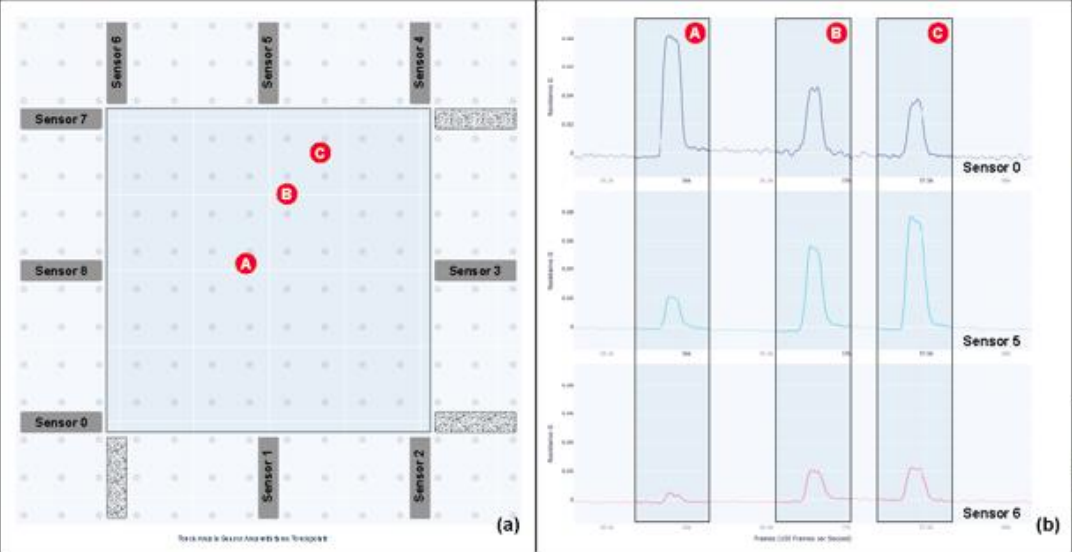

Note that there is a bias towards 0 (no touch) in the test set. <br>

The dataset is from our IHSED'23 paper [![arXiv](https://img.shields.io/badge/arXiv-2305.09222-b31b1b.svg?style=flat-square)](https://arxiv.org/abs/2305.09222). 

Have fun! 🤓

In [ ]:
import pandas as pd

# We download training and test data from GitHub. Note: there is no validation set. 
!curl -o "test.csv" "https://raw.githubusercontent.com/splendiferousnoctifer/textileTouchSensor/main/trained_models/depthMergedSensor_test.csv" --silent
!curl -o "train.csv" "https://raw.githubusercontent.com/splendiferousnoctifer/textileTouchSensor/main/trained_models/depthMergedSensor_train.csv" --silent

# Load the training and testing datasets
test_df = pd.read_csv('train.csv')
train_df = pd.read_csv('test.csv')

# Merge the 0 and 10 indent_depths (they are hard to distinguish)
train_df[train_df['state'] == 10.0] = 0.0
test_df[test_df['state'] == 10.0] = 0.0

feature_list = [ 'sensor0',	'sensor2',	'sensor3',	'sensor5',	'sensor7',	'sensor8',	'sensor9',	'sensor10',	'sensor11'] # we don't use merged_sensors
indent_levels = test_df['state'].unique()  # 0, 10 (optional), 15, 20
indent_levels.sort()
print(indent_levels)

# convert the state into classes
train_df['class'] = train_df['state'].apply(lambda x: np.where(indent_levels == x)[0][0])
test_df['class'] = test_df['state'].apply(lambda x: np.where(indent_levels == x)[0][0])

# show some stats about the training data
sample_sizes = np.asarray(train_df['state'].value_counts())
print(train_df['state'].value_counts())
print(test_df['state'].value_counts())

test_df[:15] # show a few samples

It is a neat an simple problem that is already classified very well by a simple linear classifier. <br>
However, we want to use a neural network to classify the data. <br> Let's see how well we can do! <br>

Extend the code below to train a neural network to classify the data. <br>
Note that we have training and test data, now. <br>
Experiment with the network structure and hyperparameters and see how it affects the performance. <br>
You can also try to get rid of some sensors (just modify the `feature_list` variable). <br>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Constants
LEARNING_RATE = 0.02
WEIGHT_DECAY = 1e-3  # L2 Regularization
BATCH_SIZE = 32
NUM_ITERATIONS = 10000

# Load the training data
X = train_df[feature_list].values
# One-Hot Encode the target labels
y = F.one_hot(torch.from_numpy(train_df['class'].values), len(indent_levels))

# Load the validation data. Similar as for train_df
X_val = test_df[feature_list].values
y_val = F.one_hot(torch.from_numpy(test_df['class'].values), len(indent_levels))

class LinearClassifier(nn.Module):
    """
    A model for linear classification tasks.
    """
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, xb):
        """
        Define how to perform forward pass.
        """
        return self.linear(xb)
    
# Initialize the model
model = LinearClassifier(X.shape[1], len(indent_levels))

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
#optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY) # also try with the Adam optimizer (usually better and faster convergence)

# Optimization
for k in range(NUM_ITERATIONS):
    # Create mini-batch
    if BATCH_SIZE is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:BATCH_SIZE]
        Xb, yb = X[ri], y[ri]

    # Convert numpy arrays to tensors
    Xb_t = torch.from_numpy(Xb).float()
    yb_t = (yb).long()

    # Reset gradients
    optimizer.zero_grad()

    # Perform forward pass and calculate loss
    output = model(Xb_t)
    loss = criterion(output, torch.max(yb_t, 1)[1]) # CrossEntropyLoss expects class indices, not one-hot
    
    # Perform backward pass and update weights
    loss.backward()
    optimizer.step()
    
    # Calculate accuracy
    _, predicted = torch.max(output, 1)
    _, actual = torch.max(yb_t, 1)
    correct = (predicted == actual).sum().item()
    accuracy = correct / BATCH_SIZE

    # Print progress every 100 steps
    if k % 100 == 0:        
        # Validation Part
        model.eval()  # Set model to evaluation mode (not necessary for this example but good practice for complex models)
        with torch.no_grad():
            X_val_t = torch.from_numpy(X_val).float()
            y_val_t = y_val.long()

            output_val = model(X_val_t)
            loss_val = criterion(output_val, torch.max(y_val_t, 1)[1]) 

            _, predicted_val = torch.max(output_val, 1)
            _, actual_val = torch.max(y_val_t, 1)
            val_correct = (predicted_val == actual_val).sum().item()
            val_accuracy = val_correct / X_val.shape[0]

            print(f"Iteration {k} - Training Loss: {loss.item()}, Training Accuracy: {accuracy*100:.2f}%, Validation Loss: {loss_val.item()}, Validation Accuracy: {val_accuracy*100:.2f}%")

        model.train()  # Set model back to train mode

### Let's look at the results

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize the prediction and label lists
predictions = []
targets = []

model.eval() # Set model to evaluation mode (not necessary for this example but good practice for complex models)

# Turn off gradients for validation, saves memory and computation
with torch.no_grad():
    for i in range(len(X_val)):
        
        # Forward pass
        output = model(torch.from_numpy(X_val[i]).unsqueeze(0).float())
        _, predicted = torch.max(output, 1)
        
        predictions.append(predicted.item())
        targets.append(np.argmax(y_val[i]))

# Turn on gradients again for future computations
model.train()  

# Create confusion matrix
cm = confusion_matrix(targets, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=indent_levels)
disp.plot()

# Task 5 📝: Use an MLP to classify the CIFAR-10 dataset

Take the Jupyter notebook from the previous exercise (classification with a linear classifier) and modify it to classify the CIFAR-10 dataset with an MLP. <br>
In that notebook there is a `CIFAR10` class that defines a PyTorch Module already: 
```python
class CIFAR10(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(inputSize, numClasses)
        ...
```

Modify or copy the `CIFAR10` class and change it to an MLP. The number of neurons and layers is up to you! <br>
Do you expect better or worse performance than with the linear classifier? <br>
Report the accuracy of your new network and compare it to the linear model. <br>

Note: Training a larger MLP with loads of data will take a while. So choose your hyperparameters wisely! :)

